In [2]:
from sklearn import cluster, datasets, mixture
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from sklearn.datasets import make_moons

In [3]:
noisy_moons, labels = datasets.make_moons(n_samples=500, noise=0.11)

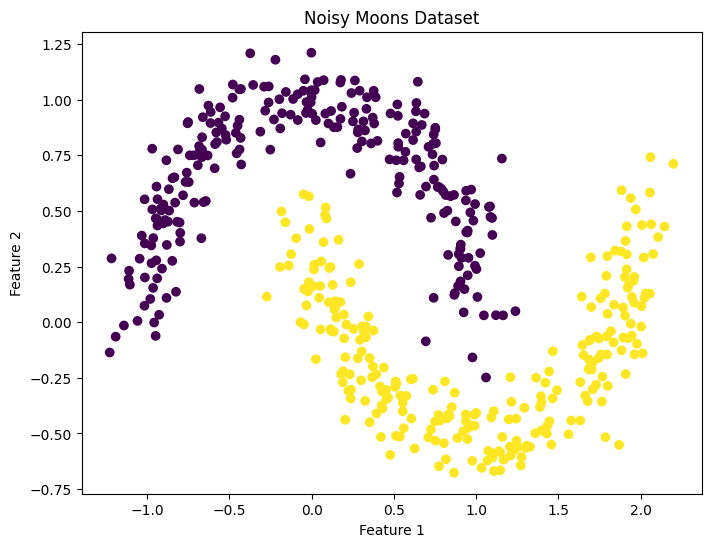

In [4]:
# Displaying the created dataset
plt.figure(figsize=(8, 6))
plt.scatter(noisy_moons[:, 0], noisy_moons[:, 1], c=labels, cmap='viridis')
plt.title("Noisy Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [5]:
# Function to calculate mean and covariance matrix manually
def calculate_mean_and_covariance(data):
    mean = np.mean(data, axis=0)
    covariance = np.dot((data - mean).T, (data - mean)) / (data.shape[0] - 1)
    return mean, covariance

In [6]:
# Function to calculate the probability density of a multivariate normal distribution
def multivariate_normal_pdf(x, mean, cov):
    k = len(mean)
    cov_det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)
    norm_factor = 1 / (np.sqrt((2 * np.pi) ** k * cov_det))
    x_minus_mu = x - mean
    return norm_factor * np.exp(-0.5 * np.dot(np.dot(x_minus_mu, cov_inv), x_minus_mu.T))

In [7]:
# Separate the dataset into two classes
class_0 = noisy_moons[labels == 0]
class_1 = noisy_moons[labels == 1]

In [8]:
# Calculate mean and covariance for each class manually
mean_0, cov_0 = calculate_mean_and_covariance(class_0)
mean_1, cov_1 = calculate_mean_and_covariance(class_1)

In [9]:
# Print the mean and covariance for each class
print("Mean for Class 0:\n", mean_0)
print("Covariance Matrix for Class 0:\n", cov_0)
print("\nMean for Class 1:\n", mean_1)
print("Covariance Matrix for Class 1:\n", cov_1)

Mean for Class 0:
 [-0.00549138  0.64610592]
Covariance Matrix for Class 0:
 [[0.52479732 0.00116374]
 [0.00116374 0.1039425 ]]

Mean for Class 1:
 [ 0.99931885 -0.14663469]
Covariance Matrix for Class 1:
 [[0.51216003 0.0033396 ]
 [0.0033396  0.10933026]]


In [10]:
# Create a grid of points to plot the contours
x_min, x_max = noisy_moons[:, 0].min() - 1, noisy_moons[:, 0].max() + 1
y_min, y_max = noisy_moons[:, 1].min() - 1, noisy_moons[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
points = np.c_[xx.ravel(), yy.ravel()]

In [11]:
# Evaluate the PDF for each class on the grid
pdf_0 = np.array([[multivariate_normal_pdf(np.array([xi, yi]), mean_0, cov_0) for xi, yi in zip(xrow, yrow)] for xrow, yrow in zip(xx, yy)])
pdf_1 = np.array([[multivariate_normal_pdf(np.array([xi, yi]), mean_1, cov_1) for xi, yi in zip(xrow, yrow)] for xrow, yrow in zip(xx, yy)])

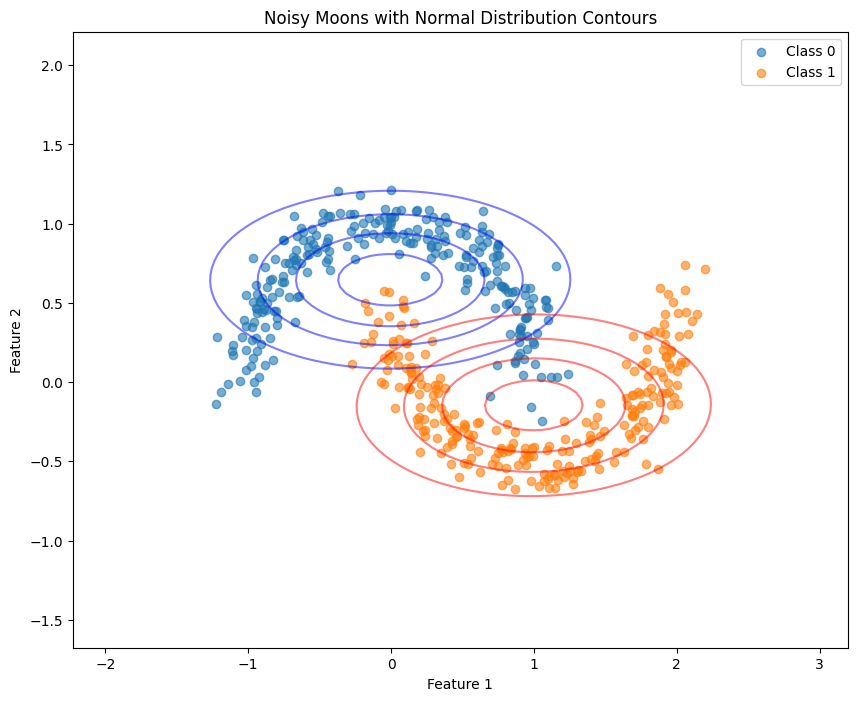

In [12]:
# Plotting the dataset and the contours
plt.figure(figsize=(10, 8))
plt.scatter(class_0[:, 0], class_0[:, 1], label='Class 0', alpha=0.6)
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', alpha=0.6)
plt.contour(xx, yy, pdf_0, levels=5, colors='blue', alpha=0.5)
plt.contour(xx, yy, pdf_1, levels=5, colors='red', alpha=0.5)
plt.title("Noisy Moons with Normal Distribution Contours")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

<ipython-input-13-4272bc9a3f6c>:75: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = Ellipse(mean, v[0], v[1], 180. + angle, edgecolor='k', lw=1)


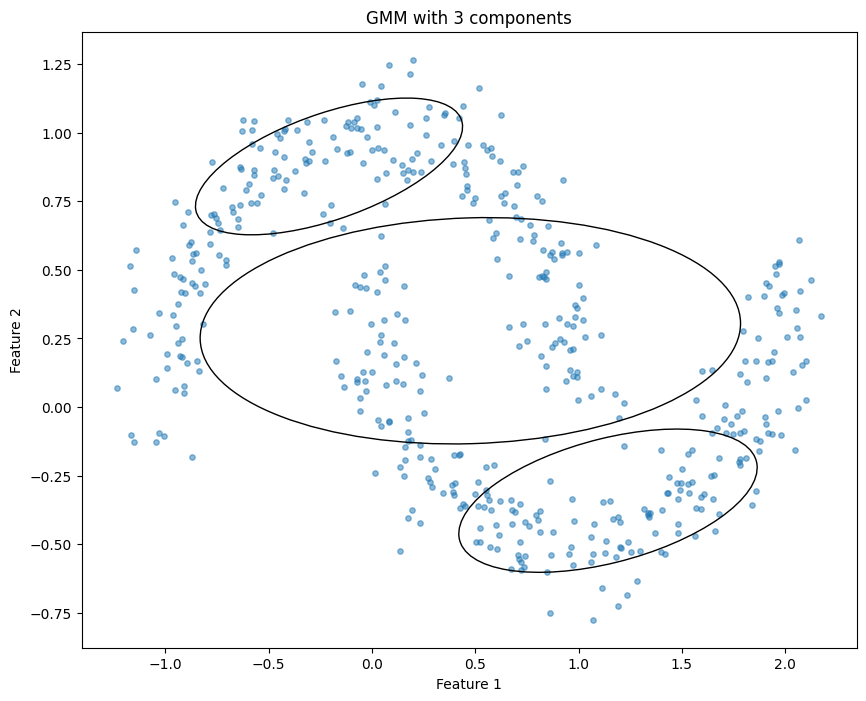

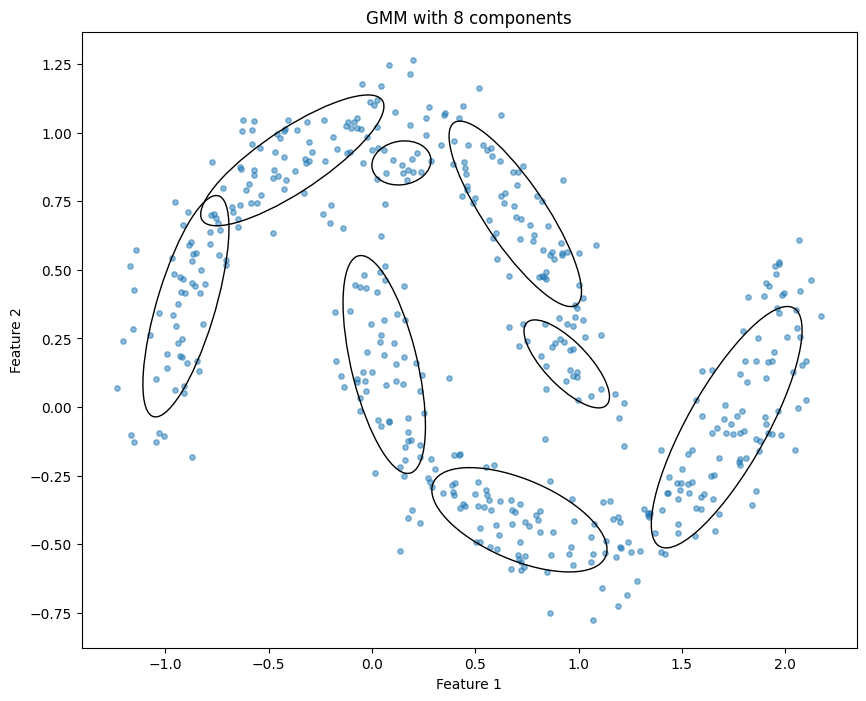

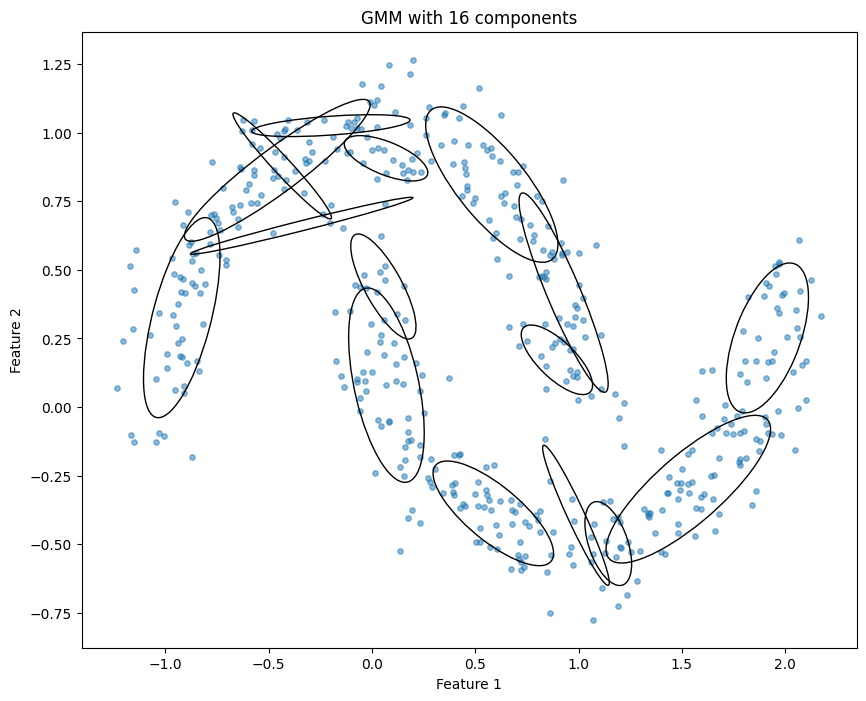

In [13]:
X, y = make_moons(n_samples=500, noise=0.11)

# Define the GMM class
class GaussianMixtureModel:
    def __init__(self, X, n_components):
        self.X = X
        self.n_components = n_components
        self.means = np.zeros((n_components, X.shape[1]))
        self.covs = np.array([np.eye(X.shape[1]) for _ in range(n_components)])
        self.weights = np.ones(n_components) / n_components
        self.resp = np.zeros((X.shape[0], n_components))

    # Multivariate Gaussian PDF
    def multivariate_gaussian(self, X, mean, cov):
        n = mean.shape[0]
        diff = X - mean
        return np.exp(-0.5 * np.sum(diff @ np.linalg.inv(cov) * diff, axis=1)) / np.sqrt((2 * np.pi) ** n * np.linalg.det(cov))

    # Expectation step
    def e_step(self):
        for k in range(self.n_components):
            self.resp[:, k] = self.weights[k] * self.multivariate_gaussian(self.X, self.means[k], self.covs[k])
        self.resp /= self.resp.sum(axis=1)[:, None]

    # Maximization step
    def m_step(self):
        Nk = self.resp.sum(axis=0)
        for k in range(self.n_components):
            self.means[k] = np.sum(self.resp[:, k, None] * self.X, axis=0) / Nk[k]
            diff = self.X - self.means[k]
            self.covs[k] = (self.resp[:, k, None] * diff).T @ diff / Nk[k]
            self.weights[k] = Nk[k] / self.X.shape[0]

    # Compute the log likelihood
    def log_likelihood(self):
        ll = 0
        for k in range(self.n_components):
            ll += self.weights[k] * self.multivariate_gaussian(self.X, self.means[k], self.covs[k])
        return np.sum(np.log(ll))

    # Fit the GMM to the data
    def fit(self, n_iters=50, tol=1e-3):
        np.random.seed(0)
        random_idx = np.random.permutation(self.X.shape[0])
        self.means = self.X[random_idx[:self.n_components]]

        ll_old = 0
        for i in range(n_iters):
            self.e_step()
            self.m_step()
            ll_new = self.log_likelihood()
            if np.abs(ll_new - ll_old) < tol:
                break
            ll_old = ll_new

# Function to plot contours for GMM
def plot_gmm(gmm, n_components):
    gmm.fit()
    plt.figure(figsize=(10, 8))
    plt.scatter(gmm.X[:, 0], gmm.X[:, 1], s=15, alpha=0.5)
    ax = plt.gca()

    for k in range(n_components):
        mean = gmm.means[k]
        cov = gmm.covs[k]

        # Eigendecomposition
        v, w = np.linalg.eigh(cov)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = Ellipse(mean, v[0], v[1], 180. + angle, edgecolor='k', lw=1)
        ell.set_facecolor('none')
        ax.add_patch(ell)

    plt.title(f'GMM with {n_components} components')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Testing GMM with 1 to 16 components and plotting for 3, 8, and 16
for n_components in [3, 8, 16]:
    gmm = GaussianMixtureModel(X, n_components)
    plot_gmm(gmm, n_components)


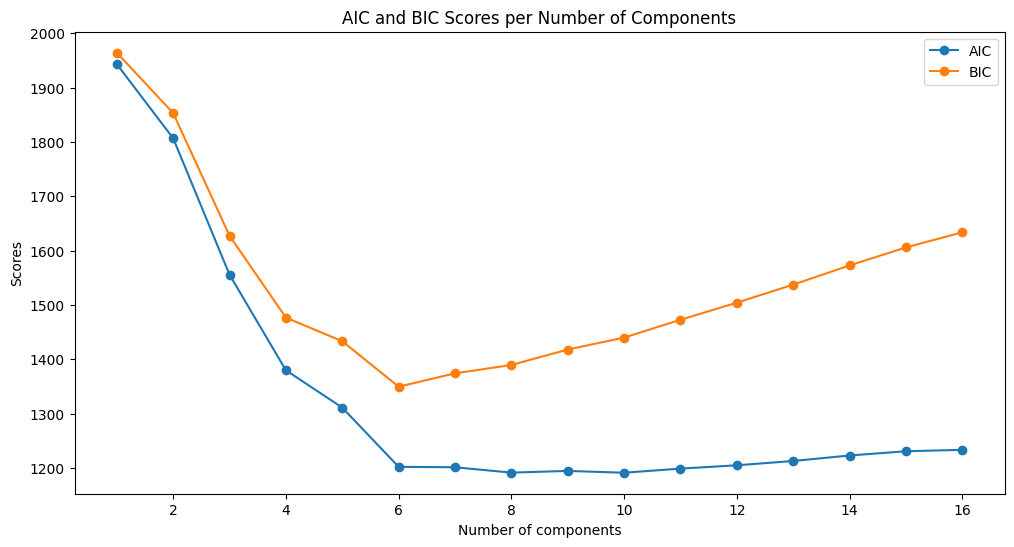

(10, 6, 1191.0279020237817, 1349.3771560169746)

In [14]:
from sklearn.mixture import GaussianMixture
# Variables to store the best AIC and BIC
best_aic = np.inf
best_bic = np.inf
best_aic_n_components = None
best_bic_n_components = None
aic_scores = []
bic_scores = []
n_components_range = range(1, 17)

# Iterate over the range of n_components
for n_components in n_components_range:
    # Create and fit the Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm.fit(noisy_moons)

    # Calculate AIC and BIC
    aic = gmm.aic(noisy_moons)
    bic = gmm.bic(noisy_moons)
    aic_scores.append(aic)
    bic_scores.append(bic)

    # Check if this model is better than previous ones
    if aic < best_aic:
        best_aic = aic
        best_aic_n_components = n_components

    if bic < best_bic:
        best_bic = bic
        best_bic_n_components = n_components

# Visualization of AIC and BIC scores
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.xlabel('Number of components')
plt.ylabel('Scores')
plt.title('AIC and BIC Scores per Number of Components')
plt.legend()
plt.show()

(best_aic_n_components, best_bic_n_components, best_aic, best_bic)
